Pairwise Training:

    Train the model on pairs of teams. For each game, 
you can have a binary outcome: either Team A wins or Team B wins. This can help the model learn the matchups more explicitly.


16
Index(['TEAM_ID', 'Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
       'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF',
       'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded', 'DRtg_Oliver_DIFF'],
      dtype='object')


C:\Users\ghadf\AppData\Local\Temp\ipykernel_15372\1206513954.py:57: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = preprocessor_data.corr()


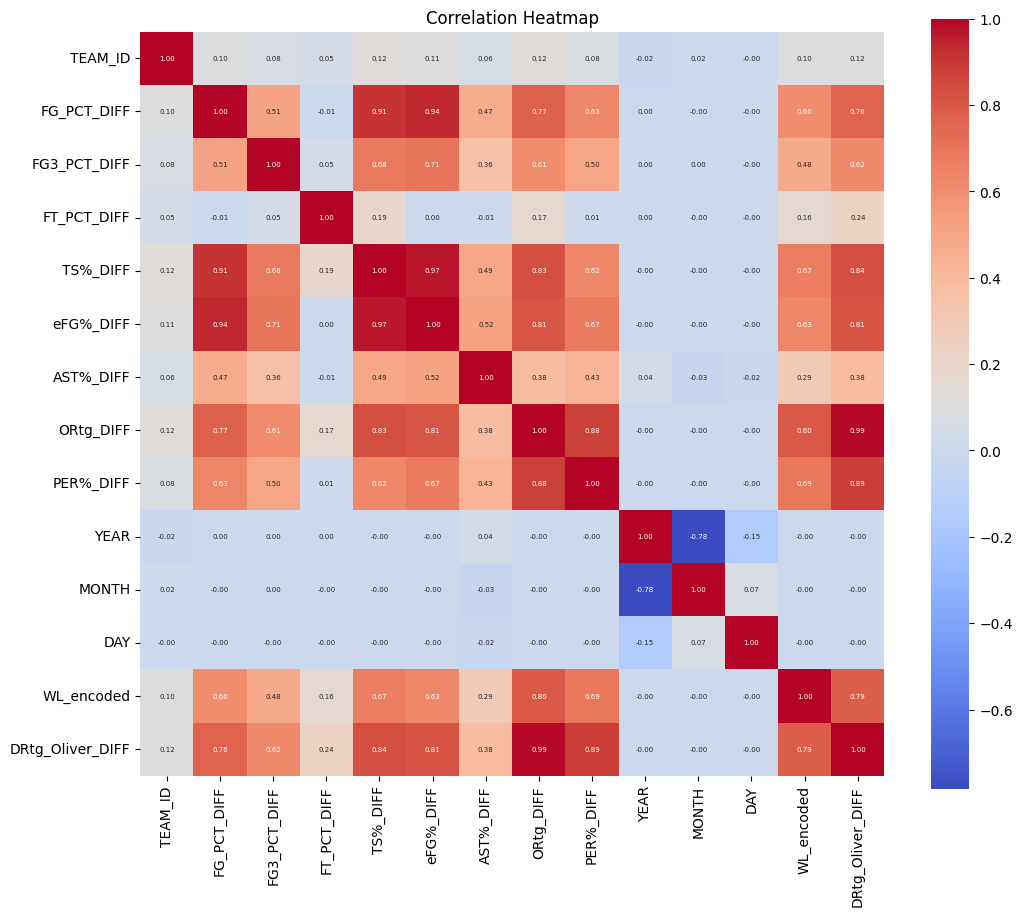

In [25]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import preprocessing
import mlflow
from mlflow.models.evaluation import evaluate
# Load the data
data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\data\nba\model_preprocessing_store\22_23_team_non_tree_data.csv')


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
preprocessor_data = data[[col for col in data.columns if col != 'WL'] + ['WL']]

#drop the columns that are not needed
x_excluded_independent_variables = [ 'TEAM_ABBREVIATION', 'WL', 'FGA', 'TOV', 'TEAM_NAME', 'GAME_ID', 'PPM', 'RPM', 'APM', 'SPM', 'BPM', 'TPM',   
                                    'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'PTS_PER_MIN_DIFF', 'PTS_DIFF',
                                    'PER', 'OPM', 'DPM', 'USG%', 'FG3A', 'OREB', 'PF', 'MIN', 'PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 
                                    'AST', 'PF', 'STL', 'BLK', 'DREB', 'Offensive_Possessions', 'SEASON_ID', 'MATCHUP', 'GAME_DATE', #, 
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP', 'SEASON_ID_OPP', 'Home_Away_OPP',  'Defensive_Possessions', #
                                     'TEAM_NAME_OPP', 'WL_OPP', 'MIN_OPP', 'PF_OPP', 'DREB_OPP','PTS_PER_MIN_OPP', 'TEAM_ID_OPP',
                                     'FG_PCT_OPP', 'FG3_PCT_OPP', 'FT_PCT_OPP', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 'Defensive_Possessions',
                                    'DRtg', 'DPER%', 'PLUS_MINUS_OPP', 'ORtg_Oliver_OPP', 'ORtg_Oliver_DIFF', 'ORtg_Oliver', 'DRtg_Oliver', 'DRtg_Oliver_OPP'
                                     ]

#drop the columns that are not needed
#preprocessor_data = preprocessor_data.drop(x_excluded_independent_variables, axis=1)

included_columns = ['TEAM_ID', 'Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
       'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF',
       'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded', 'DRtg_Oliver_DIFF']

preprocessor_data = preprocessor_data[included_columns]
print(len(preprocessor_data.columns))
print(preprocessor_data.columns)

# Create a correlation matrix for the selected columns
correlation_matrix = preprocessor_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

In [26]:
##UPDATE: because they are identification for the season and team, I would like to update my preprocessor so the variable is updated to ordinal vs non ordinal categorical variables 

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'


# Combine y_column with x_excluded_independent_variables
columns_to_drop = [y_column] #+ x_excluded_independent_variables

# Define feature lists
categorical_features = [ 'TEAM_ID', 'Home_Away', 'MATCHUP_ID'] #'SEASON_ID', 'MATCHUP', 'TEAM_ID_OPP'
numerical_features = [col for col in preprocessor_data.columns if col not in categorical_features + columns_to_drop]

# Function to label encode categorical columns for tree-based models
def label_encode_data(data, columns_to_encode):
    labelEncoder = preprocessing.LabelEncoder()
    mapping_dict = {}
    for col in columns_to_encode:
        data[col] = labelEncoder.fit_transform(data[col])
        le_name_mapping = dict(zip(labelEncoder.classes_,
                                   labelEncoder.transform(labelEncoder.classes_)))
        mapping_dict[col] = le_name_mapping
    return data, mapping_dict

# Label encode categorical features
#data, mapping_dict = label_encode_data(data, categorical_features)
#print(mapping_dict)

# Use OrdinalEncoder for the categorical columns
ordinal_encoder = OrdinalEncoder()
#preprocessor_data[categorical_features] = ordinal_encoder.fit_transform(preprocessor_data[categorical_features])

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(preprocessor_data[categorical_features])

# Transform the first dataset using the fitted encoder in a separate variable
all_encoded = preprocessor_data
#all_encoded[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
# Convert all_encoded to a pandas DataFrame
all_encoded = pd.DataFrame(all_encoded)
#print(all_encoded.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())


# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    ,('onehot', OneHotEncoder(handle_unknown='ignore')) # Use OneHotEncoder for non-tree-based models
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = all_encoded.drop(columns=columns_to_drop, axis=1)
print('before preprocessing = ', X.shape)
#print(X.head())
y = all_encoded[y_column]
#print('y shape = ', y.shape)
# view unique values in the target variable
#print(y.unique())

# Use LabelEncoder to encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#print(X.isnull().sum())
#print(X.dtypes)
# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
print('after preprocessing = ', X_preprocessed.shape)
#print X_preprocessed to see what it looks like
#print(X_preprocessed)

tmp_num = numerical_transformer.fit_transform(X[numerical_features])
print(pd.DataFrame(tmp_num, columns=numerical_features).isnull().sum())

tmp_cat = categorical_transformer.fit_transform(X[categorical_features])
print(pd.DataFrame(tmp_cat).isnull().sum())


before preprocessing =  (2938, 15)
after preprocessing =  (2938, 479)
FG_PCT_DIFF         0
FG3_PCT_DIFF        0
FT_PCT_DIFF         0
TS%_DIFF            0
eFG%_DIFF           0
AST%_DIFF           0
ORtg_DIFF           0
PER%_DIFF           0
YEAR                0
MONTH               0
DAY                 0
DRtg_Oliver_DIFF    0
dtype: int64
0    0
dtype: int64


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# convert X_train and X_test back to dense numpy arrays
X_train = X_train.toarray()
X_test = X_test.toarray()

# Convert the numpy arrays back to pandas DataFrames
#feature_names = preprocessor.transformers_[0][-1] + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
#print(feature_names)


# Fit the preprocessor first
#preprocessor.fit(X_train)

# Now access the named transformers after fitting
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])
print(len(all_feature_names))

X_train = pd.DataFrame(X_train, columns=all_feature_names)
X_test = pd.DataFrame(X_test, columns=all_feature_names)


print('Original number of features:', len(numerical_features + categorical_features))
print('Number of features after one-hot encoding:', len(all_feature_names))
print(ohe_feature_names)
print(all_feature_names)




479
Original number of features: 15
Number of features after one-hot encoding: 479
['TEAM_ID_1610612737' 'TEAM_ID_1610612738' 'TEAM_ID_1610612739'
 'TEAM_ID_1610612740' 'TEAM_ID_1610612741' 'TEAM_ID_1610612742'
 'TEAM_ID_1610612743' 'TEAM_ID_1610612744' 'TEAM_ID_1610612745'
 'TEAM_ID_1610612746' 'TEAM_ID_1610612747' 'TEAM_ID_1610612748'
 'TEAM_ID_1610612749' 'TEAM_ID_1610612750' 'TEAM_ID_1610612751'
 'TEAM_ID_1610612752' 'TEAM_ID_1610612753' 'TEAM_ID_1610612754'
 'TEAM_ID_1610612755' 'TEAM_ID_1610612756' 'TEAM_ID_1610612757'
 'TEAM_ID_1610612758' 'TEAM_ID_1610612759' 'TEAM_ID_1610612760'
 'TEAM_ID_1610612761' 'TEAM_ID_1610612762' 'TEAM_ID_1610612763'
 'TEAM_ID_1610612764' 'TEAM_ID_1610612765' 'TEAM_ID_1610612766'
 'Home_Away_Away' 'Home_Away_Home' 'MATCHUP_ID_ATLBKN' 'MATCHUP_ID_ATLBOS'
 'MATCHUP_ID_ATLCHA' 'MATCHUP_ID_ATLCHI' 'MATCHUP_ID_ATLCLE'
 'MATCHUP_ID_ATLDAL' 'MATCHUP_ID_ATLDEN' 'MATCHUP_ID_ATLDET'
 'MATCHUP_ID_ATLGSW' 'MATCHUP_ID_ATLHOU' 'MATCHUP_ID_ATLIND'
 'MATCHUP_ID_ATLLAC

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model Logistic Regression saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\logistic_regression.joblib
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       294
           1       0.93      0.94      0.94       294

    accuracy                           0.94       588
   macro avg       0.94      0.94      0.94       588
weighted avg       0.94      0.94      0.94       588



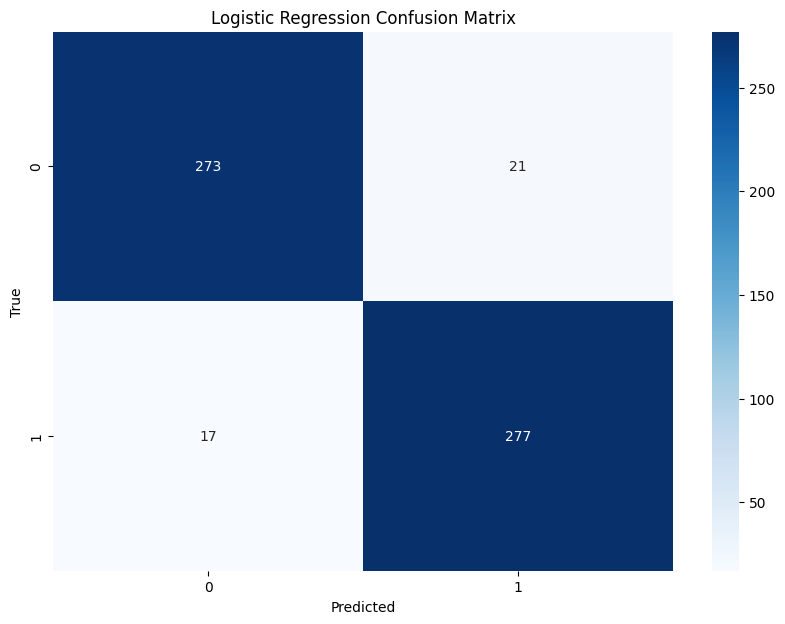

Logistic Regression Accuracy: 0.9354
--------------------------------------------------
Model Ridge Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\ridge_classifier.joblib
Ridge Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       294
           1       0.90      0.89      0.89       294

    accuracy                           0.89       588
   macro avg       0.89      0.89      0.89       588
weighted avg       0.89      0.89      0.89       588



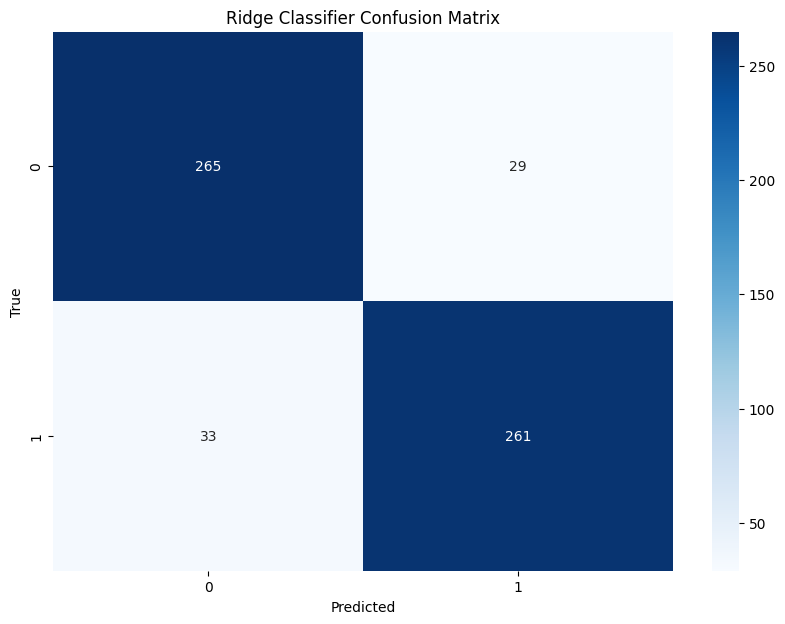

Ridge Classifier Accuracy: 0.8946
--------------------------------------------------
Model SGD Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\sgd_classifier.joblib
SGD Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       294
           1       0.90      0.95      0.93       294

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



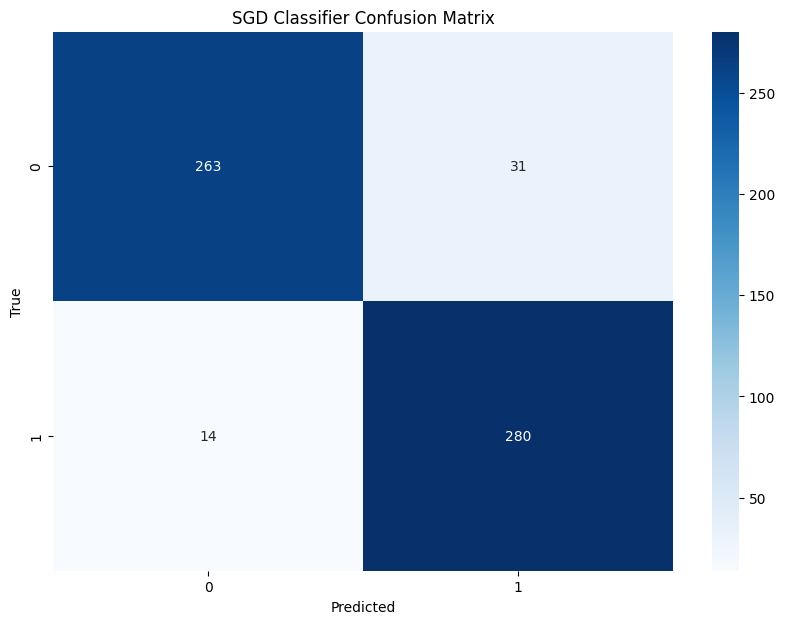

SGD Classifier Accuracy: 0.9235
--------------------------------------------------
Model SVM saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\svm.joblib
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       294
           1       0.96      0.94      0.95       294

    accuracy                           0.95       588
   macro avg       0.95      0.95      0.95       588
weighted avg       0.95      0.95      0.95       588



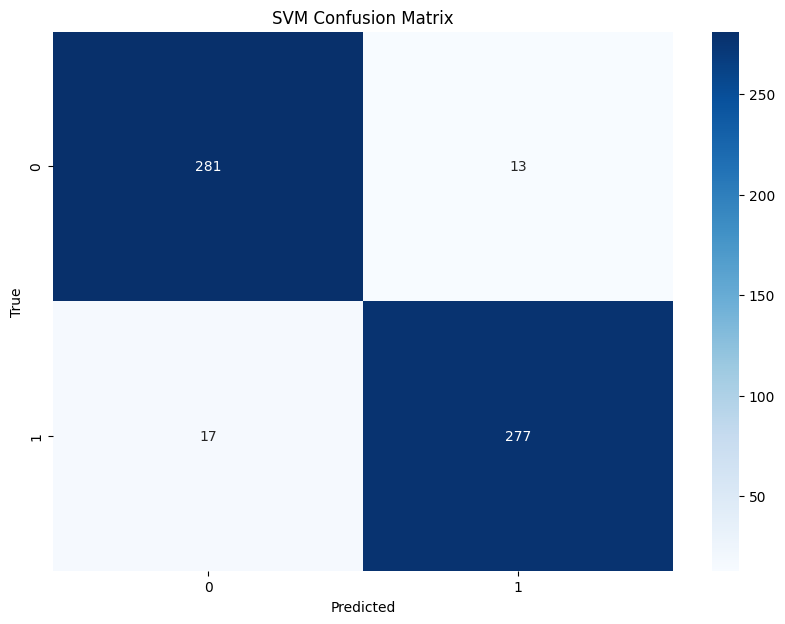

SVM Accuracy: 0.9490
--------------------------------------------------
Model Gaussian Naive Bayes saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\gaussian_naive_bayes.joblib
Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.53      0.43       294
           1       0.13      0.07      0.09       294

    accuracy                           0.30       588
   macro avg       0.25      0.30      0.26       588
weighted avg       0.25      0.30      0.26       588



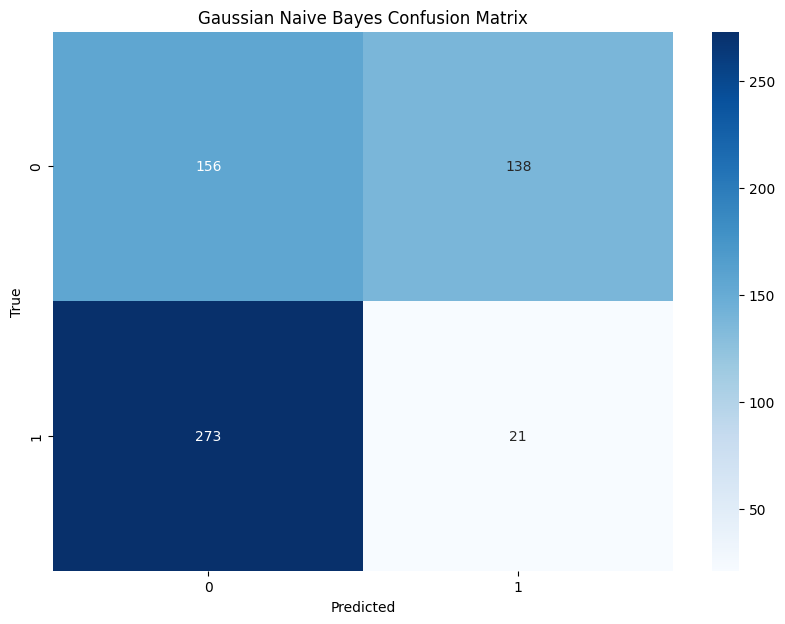

Gaussian Naive Bayes Accuracy: 0.3010
--------------------------------------------------
Model K-Neighbors Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\k-neighbors_classifier.joblib
K-Neighbors Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       294
           1       0.92      0.92      0.92       294

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



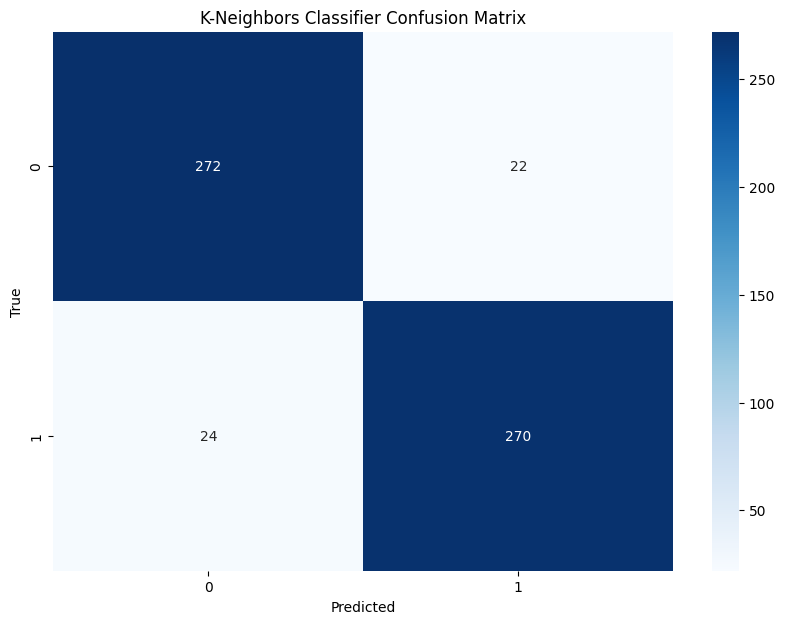

K-Neighbors Classifier Accuracy: 0.9218
--------------------------------------------------
Model MLP Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\mlp_classifier.joblib
MLP Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       294
           1       0.92      0.91      0.91       294

    accuracy                           0.91       588
   macro avg       0.92      0.91      0.91       588
weighted avg       0.92      0.91      0.91       588



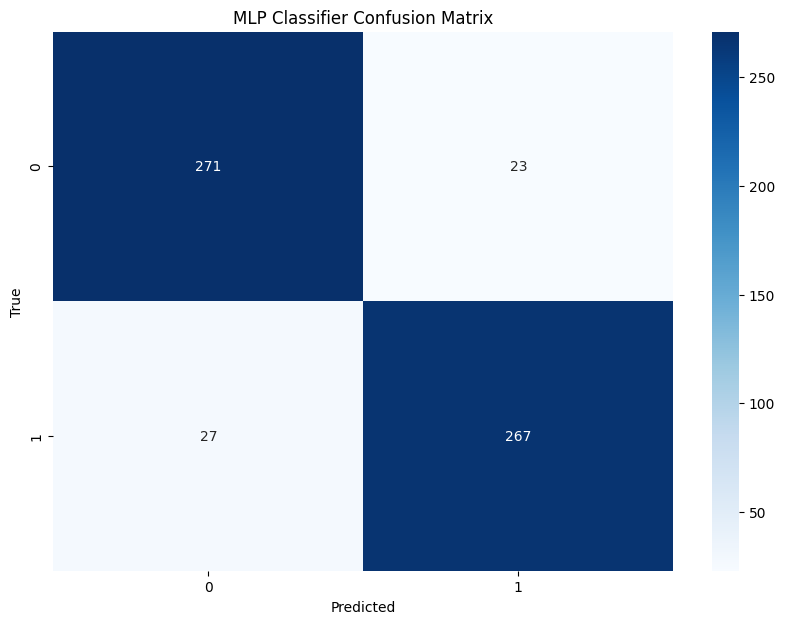

MLP Classifier Accuracy: 0.9150
--------------------------------------------------


In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from joblib import dump, load
import os

# Define the path to the directory where you want to save the models
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
# Define a function to save the models
def save_model(model, name):
    path = os.path.join(MODEL_DIR, f"{name.replace(' ', '_').lower()}.joblib")
    dump(model, path)
    return path


# Count the classes
class_counts = np.bincount(y_encoded)
# Calculate the scale_pos_weight for XGBoost
scale_pos_weight = float(class_counts[0] / class_counts[1])

# Note: Some models have hyperparameters set to avoid potential issues. 
# You should adjust these based on understanding and dataset specifics.

#Bin-classification models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=10000)),
    ("Ridge Classifier", RidgeClassifier()), 
    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
    ("Decision Tree", DecisionTreeClassifier()), 
    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("K-Neighbors Classifier", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)), # Adjusted for imbalance
    ("MLP Classifier", MLPClassifier(max_iter=1000))
]

#split the models into tree and non-tree based models
tree_models = ["XGBoost", "Decision Tree", "Random Forest", "Gradient Boosting", "AdaBoost"]
non_tree_models = ["Logistic Regression", "Ridge Classifier", "SGD Classifier", "SVM", "Gaussian Naive Bayes",
                    "K-Neighbors Classifier", "MLP Classifier"]

#filter the models variable to only include tree-based models
#models = [model for model in models if model[0] in tree_models]

# filter the models variable to only include non-tree-based models
models = [model for model in models if model[0] in non_tree_models]
#print(models)


num_classes = len(np.unique(y_encoded))

#Multi-classification models
#models = [
#    ("Logistic Regression", LogisticRegression(multi_class='ovr', max_iter=10000)),
#    ("Ridge Classifier", RidgeClassifier()), 
#    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
#    ("Decision Tree", DecisionTreeClassifier()), 
#    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
#    ("Gradient Boosting", GradientBoostingClassifier()),
#    ("AdaBoost", AdaBoostClassifier(algorithm='SAMME')),
#    ("SVM", SVC(probability=True)), # Added probability=True for decision boundary plotting
#    ("Gaussian Naive Bayes", GaussianNB()),
#    ("K-Neighbors Classifier", KNeighborsClassifier()),
#    ("XGBoost", XGBClassifier(use_label_encoder=False, 
#                              eval_metric="mlogloss", 
#                              objective="multi:softprob", 
#                              num_class=num_classes)), 
#    ("MLP Classifier", MLPClassifier(max_iter=1000))
#]


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


def display_confusion_matrix(classifier, X_test, y_test):
    matrix = confusion_matrix(y_test, classifier.predict(X_test), labels=classifier.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d",
                xticklabels=classifier.classes_,
                yticklabels=classifier.classes_, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

from sklearn.decomposition import PCA

from sklearn.base import clone

# Continue using your PCA as before
#pca = PCA(n_components=2)
#X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

# Train models, plot decision boundaries, and display confusion matrices
results = []
for name, model in models:
    model.fit(X_train, y_train)  # Training on original data
    y_pred = model.predict(X_test)  # Predicting on original data
    
    # Save the trained model
    saved_path = save_model(model, name)
    print(f"Model {name} saved to {saved_path}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    
    # Display classification report
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:")
    print(report)
    
    # Display confusion matrix (using the original X_test)
    display_confusion_matrix(model, X_test, y_test)  
    
    # Now for the decision boundary, we need to train the model again on PCA data.
    # Clone the model to avoid refitting the original one
    #model_clone = clone(model)
    #model_clone.fit(X_train_pca, y_train)
    
    # Plot decision boundaries using the model trained on PCA data
    #plt.figure(figsize=(10,6))
    #plot_decision_boundary(lambda x: model_clone.predict(x), X_train_pca, y_train)
    #plt.title(name)
    #plt.show()
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("--------------------------------------------------")



In [29]:
# Fit the encoder on the first dataset's categorical columns
#ordinal_encoder.fit(data[categorical_features])

#save the ordinal_encoder, label_encoder, and preprocessor to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing


MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing"
saved_path = save_model(preprocessor, 'nontree_preprocessor')
#saved_path = save_model(label_encoder, 'label_encoder')
#saved_path = save_model(ordinal_encoder, 'ordinal_encoder')
print(f"Model saved to {saved_path}")

Model saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\nontree_preprocessor.joblib


In [30]:
#read "unseen" data so we can test what these models would predict for the 2022 playoffs
#prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv')
prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

print(prediction_data.head())

# Drop the columns that are not needed Matchup
prediction_data = prediction_data.drop(columns=['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', ])#, 'PLUS_MINUS'
    
included_columns = ['TEAM_ID', 'Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
       'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF',
       'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded', 'DRtg_Oliver_DIFF']



feature_order = [#'PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'TEAM_ID_OPP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS',  'FG_PCT_OPP', 'FG3_PCT_OPP',  'SEASON_ID', 'GAME_ID'
                   #'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'FT_PCT_OPP', 'PLUS_MINUS_OPP','TS%_OPP', 'eFG%_OPP', 'AST%_OPP', , 'MATCHUP'
                  'Home_Away', 'YEAR', 'MONTH', 'DAY', 'MATCHUP_ID','TEAM_ID', #'DRtg', 'DPER%',
                 'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF', 'DRtg_Oliver_DIFF'] #, 'MATCHUP'

prediction_data = prediction_data[included_columns]
#prediction_data = prediction_data.drop(x_excluded_independent_variables, axis=1)

#does feature_names = feature_order?
print(len(included_columns))
print(len(feature_order))

# Reorder columns in the new_data DataFrame
prediction_data = prediction_data[feature_order]
print(prediction_data.head())
print(prediction_data.shape)

  Home_Away  WL_encoded     TEAM_ID  TEAM_ID_OPP  YEAR  MONTH  DAY MATCHUP_ID  \
0      Home         NaN  1610612737   1610612748  2023     11   11     ATLMIA   
1      Away         NaN  1610612761   1610612738  2023     11   11     BOSTOR   
2      Home         NaN  1610612738   1610612761  2023     11   11     BOSTOR   
3      Away         NaN  1610612748   1610612737  2023     11   11     ATLMIA   
4      Away         NaN  1610612739   1610612744  2023     11   11     CLEGSW   

         Date    PTS   FGM   FGA  FG3M  FG3A   FTM   FTA   AST  OREB   TOV  \
0  2023-11-11  109.5  40.0  82.0  11.5  31.5  18.0  20.5  25.5   5.0  12.5   
1  2023-11-11   97.5  38.5  91.5   7.5  32.0  13.0  17.0  20.5  12.5   9.0   
2  2023-11-11  109.0  41.5  85.0  13.0  41.0  13.0  19.5  28.5  12.0  17.0   
3  2023-11-11  109.5  41.5  85.5   8.5  32.0  18.0  19.5  29.0   9.0  13.0   
4  2023-11-11  101.0  37.0  92.0   8.0  30.0  19.0  26.0  25.0  14.0  10.0   

    STL  BLK   REB    MIN  DREB  ORtg_Oliver

In [31]:
#############################################################################################################

#load the encoder from C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
ordinal_encoder = load(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib')

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])

#save the encoder to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
saved_path = save_model(ordinal_encoder, 'ordinal_encoder')
print(f"Model saved to {saved_path}")

# Transform the categorical columns in dataset1 using the fitted encoder
#print(data.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())

print(prediction_data.head())
# Use OrdinalEncoder for the categorical columns
#prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])
print(prediction_data.head())

# Check if the categorical columns in dataset1 and dataset2 are the same
if set(prediction_data[categorical_features]) != set(preprocessor_data[categorical_features]):
    raise ValueError("Categorical columns in dataset1 do not match dataset2")


Model saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib
  Home_Away  YEAR  MONTH  DAY MATCHUP_ID     TEAM_ID  FG_PCT_DIFF  \
0      Home  2023     11   11     ATLMIA  1610612737    -0.002425   
1      Away  2023     11   11     BOSTOR  1610612761     0.067470   
2      Home  2023     11   11     BOSTOR  1610612738    -0.067470   
3      Away  2023     11   11     ATLMIA  1610612748     0.002425   
4      Away  2023     11   11     CLEGSW  1610612739     0.085631   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0     -0.099454     0.045028 -0.019565  -0.022839   2.820568   0.498611   
1      0.082698    -0.098039  0.089866   0.102957  11.125040   8.454469   
2     -0.082698     0.098039 -0.089866  -0.102957 -11.125040  -8.454469   
3      0.099454    -0.045028  0.019565   0.022839  -2.820568  -0.498611   
4      0.150000     0.054945  0.112974   0.133616   8.191941  

In [32]:
#load in preprocessing from C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
preprocessor = load(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\nontree_preprocessor.joblib')

# Preprocess X_new
X_new_preprocessed = preprocessor.transform(prediction_data)
# Convert X_new_preprocessed to a dense numpy array
X_new_preprocessed = X_new_preprocessed.toarray()
#print(X_new_preprocessed.shape)
#print(len(all_feature_names))


#print(X_new_preprocessed)
X_unseen_preprocessed = pd.DataFrame(X_new_preprocessed, columns=all_feature_names)
print(X_unseen_preprocessed.head())


   FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  \
0    -0.032423     -0.845628     0.329625 -0.234094  -0.253114  -4.468212   
1     0.911274      0.702855    -0.716899  1.075258   1.141021  -3.003098   
2    -0.910643     -0.703183     0.717395 -1.075258  -1.141021  -6.928562   
3     0.033054      0.845300    -0.329128  0.234094   0.253114  -5.463448   
4     1.156473      1.274990     0.402166  1.351753   1.480797  -3.520569   

   ORtg_DIFF  PER%_DIFF      YEAR     MONTH      DAY  DRtg_Oliver_DIFF  \
0   0.034215   0.576098  0.721598  1.011751 -0.49002          0.102518   
1   0.580158   0.401360  0.721598  1.011751 -0.49002          0.495481   
2  -0.580158  -0.401360  0.721598  1.011751 -0.49002         -0.495481   
3  -0.034215  -0.576098  0.721598  1.011751 -0.49002         -0.102518   
4   0.755217   0.629398  0.721598  1.011751 -0.49002          0.900742   

   TEAM_ID_1610612737  TEAM_ID_1610612738  TEAM_ID_1610612739  \
0                 1.0      

In [33]:
# Load the trained logistic_regression model
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
logistic_regression = os.path.join(MODEL_DIR, "logistic_regression.joblib")
trained_rf = load(logistic_regression)

# Predict using the trained model
predictions_rf = trained_rf.predict(X_unseen_preprocessed)

# Convert predictions back from encoded form to original labels
decoded_predictions_rf = label_encoder.inverse_transform(predictions_rf)

# Add predictions as a new column to the original dataframe
prediction_data['PREDICTION'] = decoded_predictions_rf

# Inverse transform the encoded categorical columns back to their original form
#prediction_data[categorical_features] = ordinal_encoder.inverse_transform(prediction_data[categorical_features])

# Display the results with the original values
#print(prediction_data.head())

# put YEAR, MONTH, DAY into a date column
prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
#sort by date
prediction_data = prediction_data.sort_values(by=['Date'])
print(prediction_data.head())

  Home_Away  YEAR  MONTH  DAY MATCHUP_ID     TEAM_ID  FG_PCT_DIFF  \
0      Home  2023     11   11     ATLMIA  1610612737    -0.002425   
1      Away  2023     11   11     BOSTOR  1610612761     0.067470   
2      Home  2023     11   11     BOSTOR  1610612738    -0.067470   
3      Away  2023     11   11     ATLMIA  1610612748     0.002425   
4      Away  2023     11   11     CLEGSW  1610612739     0.085631   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0     -0.099454     0.045028 -0.019565  -0.022839   2.820568   0.498611   
1      0.082698    -0.098039  0.089866   0.102957  11.125040   8.454469   
2     -0.082698     0.098039 -0.089866  -0.102957 -11.125040  -8.454469   
3      0.099454    -0.045028  0.019565   0.022839  -2.820568  -0.498611   
4      0.150000     0.054945  0.112974   0.133616   8.191941  11.005556   

   PER%_DIFF  DRtg_Oliver_DIFF  PREDICTION       Date  
0  12.740352          1.502842           0 2023-11-11  
1   8.876040          

In [34]:
# Assuming you've already read in your df1
unique_teams = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')

# take only the first 
#unique_teams = unique_teams.drop_duplicates(subset='TEAM_ID', keep='first')

#print(unique_teams.head())

print(len(prediction_data))
# Merge unique_teams with prediction_data
prediction_data = prediction_data.merge(unique_teams, on='TEAM_ID', how='left')
print(prediction_data.head())
print(len(prediction_data))

# Drop unnecessary columns
columns_to_drop = ["TEAM_ID", "YEAR", "MONTH", "DAY"]
prediction_data = prediction_data.drop(columns=columns_to_drop)  # using errors='ignore' to avoid any error if columns are not present

# filter for todays games
today = pd.Timestamp.today().normalize()
prediction_data = prediction_data[prediction_data['Date'] == today]


8
  Home_Away  YEAR  MONTH  DAY MATCHUP_ID     TEAM_ID  FG_PCT_DIFF  \
0      Home  2023     11   11     ATLMIA  1610612737    -0.002425   
1      Away  2023     11   11     BOSTOR  1610612761     0.067470   
2      Home  2023     11   11     BOSTOR  1610612738    -0.067470   
3      Away  2023     11   11     ATLMIA  1610612748     0.002425   
4      Away  2023     11   11     CLEGSW  1610612739     0.085631   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  \
0     -0.099454     0.045028 -0.019565  -0.022839   2.820568   0.498611   
1      0.082698    -0.098039  0.089866   0.102957  11.125040   8.454469   
2     -0.082698     0.098039 -0.089866  -0.102957 -11.125040  -8.454469   
3      0.099454    -0.045028  0.019565   0.022839  -2.820568  -0.498611   
4      0.150000     0.054945  0.112974   0.133616   8.191941  11.005556   

   PER%_DIFF  DRtg_Oliver_DIFF  PREDICTION       Date            TEAM_NAME  \
0  12.740352          1.502842           0 2023-11-11 

In [35]:
from datetime import datetime
import pandas as pd
import os

# 1. Create a DataFrame for today's outcomes based on prediction_data
today_predictions = prediction_data.copy()


for name, model in models:
    predictions_model = model.predict(X_unseen_preprocessed)
    decoded_predictions_model = label_encoder.inverse_transform(predictions_model)
    today_predictions[f'{name}_PREDICTION'] = decoded_predictions_model

print(today_predictions.columns)
# 2. Add today's date and recording timestamp
today_predictions['date_prediction_recorded'] = pd.Timestamp.today()

#filter for ATLCHA matchup_id
#today_predictions = today_predictions[today_predictions['MATCHUP_ID'] == 'ATLCHA']

# Define the path to the saved predictions
saved_predictions_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\non_tree_season_pred.csv'

# 3. Check if the saved predictions file exists
if not os.path.exists(saved_predictions_path):
    # If it doesn't exist, create it from today's predictions
    today_predictions.to_csv(saved_predictions_path, index=False)
    print(today_predictions.shape)
else:
    # If it exists, load it and update
    saved_predictions = pd.read_csv(saved_predictions_path)
    # Normalize the 'Date' column to remove time portion
    saved_predictions['Date'] = pd.to_datetime(saved_predictions['Date']).dt.normalize()

    print(saved_predictions.shape)

    print(today_predictions.shape)
    # 4. Concatenate existing and new predictions
    all_predictions = pd.concat([saved_predictions, today_predictions], ignore_index=True)
    
    # 5. Sort by date recorded, matchup id, and home_away
    all_predictions.sort_values(by=['date_prediction_recorded', 'MATCHUP_ID', 'Home_Away'], ascending=[True, True, True], inplace=True)
    
    # 6. Remove duplicates, keeping only the newest entry
    all_predictions.drop_duplicates(subset=['MATCHUP_ID', 'TEAM_NAME', 'Date'], keep='first', inplace=True)
    
    # Sort by date and reset index
    all_predictions = all_predictions.sort_values(by=['Date']).reset_index(drop=True)
    
    # 7. Save the updated DataFrame back to CSV
    all_predictions.to_csv(saved_predictions_path, index=False)

# 8. Display the results
print(all_predictions.columns)
print(all_predictions.shape)
#print(all_predictions.head())

Index(['Home_Away', 'MATCHUP_ID', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF',
       'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF',
       'DRtg_Oliver_DIFF', 'PREDICTION', 'Date', 'TEAM_NAME',
       'TEAM_ABBREVIATION', 'Logistic Regression_PREDICTION',
       'Ridge Classifier_PREDICTION', 'SGD Classifier_PREDICTION',
       'SVM_PREDICTION', 'Gaussian Naive Bayes_PREDICTION',
       'K-Neighbors Classifier_PREDICTION', 'MLP Classifier_PREDICTION'],
      dtype='object')
(493, 35)
(8, 23)
Index(['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'FG_PCT', 'FG3_PCT',
       'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'MATCHUP_ID', 'TS%', 'ORtg',
       'PER%', 'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF',
       'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF',
       'PREDICTION', 'Date', 'TEAM_NAME', 'TEAM_ABBREVIATION',
       'Logistic Regression_PREDICTION', 'Ridge Classifier_PREDICTION',
       'SGD Classifier_PREDICTION', 'SVM_PREDICTION',

In [36]:
#Log Regression Example
# sum prediction column by matchup_id
today_predictions['prediction_sum'] = today_predictions.groupby('MATCHUP_ID')['PREDICTION'].transform('sum')
#filter non 1's in count
#today_predictions = today_predictions[today_predictions['prediction_sum'] != 1]
print(today_predictions[['MATCHUP_ID', 'TEAM_NAME', 'PREDICTION', 'prediction_sum']])


  MATCHUP_ID              TEAM_NAME  PREDICTION  prediction_sum
0     ATLMIA          Atlanta Hawks           0               0
1     BOSTOR        Toronto Raptors           1               1
2     BOSTOR         Boston Celtics           0               1
3     ATLMIA             Miami Heat           0               0
4     CLEGSW    Cleveland Cavaliers           1               1
5     CLEGSW  Golden State Warriors           0               1
6     MILORL          Orlando Magic           1               1
7     MILORL        Milwaukee Bucks           0               1
